In [1]:
import chempy
import numpy as np
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt
%matplotlib inline
sp.__version__, chempy.__version__

('1.4', '0.7.8')

In [2]:
## ALLL CREDIT GOES TO CHEMPY AUTHORS 

## ALso I am in a virtual environment that I called kittens just to remind myself that I need to activate kittens
from chempy import balance_stoichiometry  # Main reaction in NASA's booster rockets:
from pprint import pprint
from chempy import mass_fractions

In [3]:
reaction, product = balance_stoichiometry({'HCOOH'},{'H2','CO2'})#,'CO','H2O'})

In [4]:
reaction

OrderedDict([('HCOOH', 1)])

In [5]:
product

OrderedDict([('CO2', 1), ('H2', 1)])

In [6]:
pprint(dict(reaction))

{'HCOOH': 1}


In [7]:
pprint(dict(product))

{'CO2': 1, 'H2': 1}


In [8]:
for fractions in map(mass_fractions, [reaction, product]):
    pprint({k: '{0:.4g} wt%'.format(v*100) for k, v in fractions.items()})
    # .4g is for the number of sig figs 

{'HCOOH': '100.0 wt%'}
{'CO2': '95.62 wt%', 'H2': '4.380 wt%'}


In [9]:
reaction, product = balance_stoichiometry({'HCOOH'},{'CO','H2O'})

In [10]:
for fractions in map(mass_fractions, [reaction, product]):
    pprint({k: '{0:.4g} wt%'.format(v*100) for k, v in fractions.items()})
    # .4g is for the number of sig figs 

{'HCOOH': '100.0 wt%'}
{'CO': '60.86 wt%', 'H2O': '39.14 wt%'}


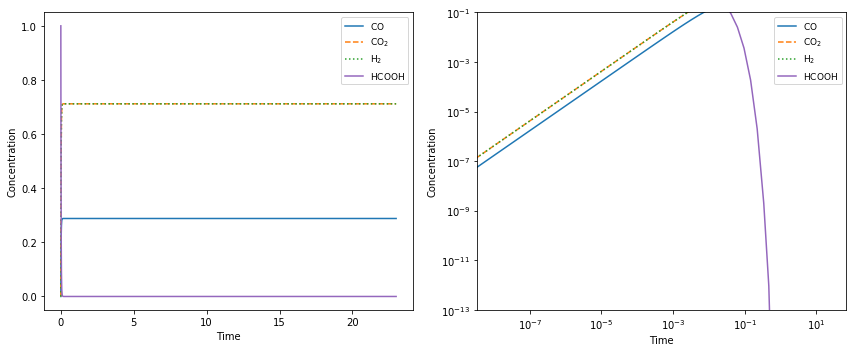

In [11]:
from chempy import ReactionSystem  # The rate constants below are arbitrary
rsys = ReactionSystem.from_string("""
HCOOH -> H2 + CO2; 42
HCOOH -> H2O + CO; 17
""")  # "[H2O]" = 1.0 (actually 55.4 at RT)
from chempy.kinetics.ode import get_odesys
odesys, extra = get_odesys(rsys)
from collections import defaultdict
import numpy as np
tout = sorted(np.concatenate((np.linspace(0, 23), np.logspace(-8, 1))))
# Initial Concentrations
c0 = defaultdict(float, {'HCOOH': 1.00, 'H2': 0.00, 'CO2': 0.000, 'H2O': 0.00, 'CO': 0.00})
result = odesys.integrate(tout, c0, atol=1e-12, rtol=1e-14)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
    result.plot(names=[k for k in rsys.substances if k != 'H2O'], ax=ax)
    ax.legend(loc='best', prop={'size': 9})
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
axes[1].set_ylim([1e-13, 1e-1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
fig.tight_layout()
#fig.savefig('examples/kinetics.png', dpi=72)

In [12]:
rsys

In [13]:
odesys

In [14]:
extra

{'param_keys': [],
 'unique': OrderedDict(),
 'p_units': None,
 'max_euler_step_cb': <function chempy.kinetics.ode.get_odesys.<locals>.max_euler_step_cb(x, y, p=())>,
 'linear_dependencies': <function chempy.kinetics.ode.get_odesys.<locals>.linear_dependencies(preferred=None)>,
 'rate_exprs_cb': <pyodesys.util._Callback at 0x1f914adbb70>,
 'cstr_fr_fc': False,
 'unit_registry': None}

In [15]:
 # EXAMPLE KINETIC MODEL
from __future__ import absolute_import, division, print_function
from collections import defaultdict
from ipywidgets import interact
import matplotlib.pyplot as plt
from chempy import Reaction, Substance, ReactionSystem
from chempy.kinetics.ode import get_odesys
from chempy.kinetics.analysis import plot_reaction_contributions
from chempy.printing.tables import UnimolecularTable, BimolecularTable
from chempy.util.graph import rsys2graph
import sympy
sympy.init_printing()
%matplotlib inline

In [16]:
A, B, C, D, E, F= map(Substance, 'ABCDEF')

In [17]:
One = sympy.S.One


In [18]:
reactions = r0, r1 = [
    Reaction({'A'}, {'B', 'C'}, 4*One/100, name='R1: A cons.'),
    Reaction({'A'}, {'D', 'E'}, 3*One/100, name='R2: A cons.'),
]

In [19]:
reactions

In [20]:
rsys = ReactionSystem(reactions, (A, B, C, D, E))


In [21]:
rsys

In [22]:
uni, not_uni = UnimolecularTable.from_ReactionSystem(rsys)
bi, not_bi = BimolecularTable.from_ReactionSystem(rsys)
#assert not (not_uni & not_bi), "There are only uni- & bi-molecular reactions in this set"

In [23]:
uni

A,"R1: A cons., R2: A cons."
B,
C,
D,
E,


In [24]:
bi

A,,,,,
B,-,,,,
C,-,-,,,
D,-,-,-,,
E,-,-,-,-,


In [25]:
not_uni

In [26]:
not_bi

In [27]:
odesys, extra = get_odesys(rsys, include_params=True)
odesys.exprs

In [28]:
odesys.get_jac()

⎡-7/100  0  0  0  0⎤
⎢                  ⎥
⎢ 1/25   0  0  0  0⎥
⎢                  ⎥
⎢ 1/25   0  0  0  0⎥
⎢                  ⎥
⎢3/100   0  0  0  0⎥
⎢                  ⎥
⎣3/100   0  0  0  0⎦

In [29]:
c0 = defaultdict(float, {'A': 1})
result = odesys.integrate(1e10, c0, integrator='cvode', nsteps=2000)
{k: v for k, v in result.info.items() if not k.startswith('internal')}

c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed test compilation of '#include <math.h>':
 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed to include math.h: 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed test compilation of '#include <sundials/sundials_config.h>':
 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: sundials not in include path, set e.g. $CPLUS_INCLUDE_PATH ():

  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed test compilation of '
    #include <sundials/sundials_config.h>
    #if SUNDIALS_VERSION_MAJOR >= 3
    #include <stdi

{'n_nonlin_solv_iters': 233,
 'n_steps': 186,
 'n_dls_jac_evals': 4,
 'n_nonlin_solv_conv_fails': 0,
 'n_root_evals': 0,
 'n_rhs_evals': 234,
 'n_lin_solv_setups': 48,
 'n_err_test_fails': 8,
 'n_dls_rhs_evals': 0,
 'njvev': 0,
 'nfev': 234,
 'njev': 4,
 'time_cpu': 0.02,
 'time_jtimes': 0.0,
 'time_jac': 0.000334932,
 'time_wall': 0.019504615,
 'time_rhs': 0.018164031000000014,
 'time_prec': 0.0,
 'time_quads': 0.0,
 'time_roots': 0.0,
 'steps': array([], dtype=float64),
 'orders': array([], dtype=int32),
 'fpes': array([], dtype=int32),
 'success': True,
 'atol': [1e-08],
 'rtol': 1e-08,
 'mode': 'adaptive'}

In [30]:
odesys

In [31]:
extra

{'param_keys': [],
 'unique': OrderedDict(),
 'p_units': None,
 'max_euler_step_cb': None,
 'linear_dependencies': None,
 'rate_exprs_cb': <pyodesys.util._Callback at 0x1f917568ba8>,
 'cstr_fr_fc': False,
 'unit_registry': None}

In [32]:
extra['rate_exprs_cb'](result.xout, result.yout)

array([[ 4.00000000e-02,  3.00000000e-02],
       [ 3.99999791e-02,  2.99999844e-02],
       [ 3.99967271e-02,  2.99975453e-02],
       [ 3.99865668e-02,  2.99899251e-02],
       [ 3.99764087e-02,  2.99823065e-02],
       [ 3.99662532e-02,  2.99746899e-02],
       [ 3.99561001e-02,  2.99670751e-02],
       [ 3.99346578e-02,  2.99509933e-02],
       [ 3.98952558e-02,  2.99214418e-02],
       [ 3.98203854e-02,  2.98652891e-02],
       [ 3.96304666e-02,  2.97228500e-02],
       [ 3.95263476e-02,  2.96447607e-02],
       [ 3.94225021e-02,  2.95668765e-02],
       [ 3.93189294e-02,  2.94891970e-02],
       [ 3.91159337e-02,  2.93369503e-02],
       [ 3.89139863e-02,  2.91854897e-02],
       [ 3.87130818e-02,  2.90348113e-02],
       [ 3.85132147e-02,  2.88849110e-02],
       [ 3.83143795e-02,  2.87357846e-02],
       [ 3.79337531e-02,  2.84503148e-02],
       [ 3.73264129e-02,  2.79948096e-02],
       [ 3.67287969e-02,  2.75465977e-02],
       [ 3.61407485e-02,  2.71055614e-02],
       [ 3.

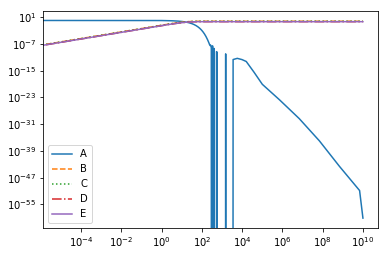

In [33]:
result.plot(xscale='log', yscale='log')

c:\users\user1\anaconda3\envs\kittens\lib\site-packages\chempy\kinetics\analysis.py:86: RuntimeWarning: divide by zero encountered in true_divide
  factor = 1/xyp[1][:, rsys.as_substance_index(sk)] if relative else 1


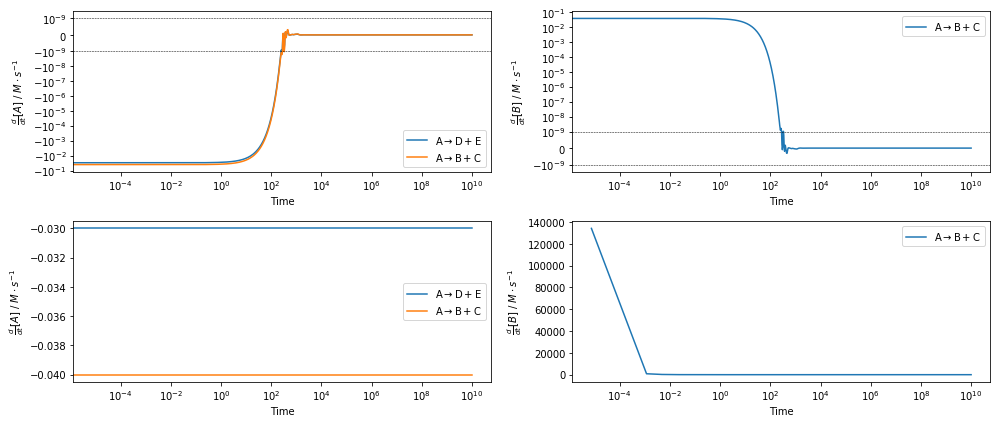

In [34]:
# PLOTTING THE REACTION CONTRIBUTIONS DIRECTLY FROM CHEMPY ROBERTSON
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
plot_reaction_contributions(result, rsys, extra['rate_exprs_cb'], 'AB', axes=axes[0, :])
plot_reaction_contributions(result, rsys, extra['rate_exprs_cb'], 'AB', axes=axes[1, :],
                            relative=True, yscale='linear')
plt.tight_layout()



In [35]:
str_massaction = """
A -> B + C; 'k1'
A -> D + E; 'k2'
"""

In [36]:
rsys3 = ReactionSystem.from_string(str_massaction, substance_factory=lambda formula: Substance(formula))

In [37]:
str_massaction

"\nA -> B + C; 'k1'\nA -> D + E; 'k2'\n"

In [38]:
rsys3

In [39]:
odesys3, extra3 = get_odesys(rsys3, include_params=False, lower_bounds=[0, 0, 0,0,0])
extra3['param_keys'], extra3['unique']

([], OrderedDict([('k1', None), ('k2', None)]))

In [40]:
odesys3.exprs, odesys3.params, odesys3.names, odesys3.param_names

((-p_0*y_0 - p_1*y_0, p_0*y_0, p_0*y_0, p_1*y_0, p_1*y_0),
 (p_0, p_1),
 ('A', 'B', 'C', 'D', 'E'),
 ('k1', 'k2'))

In [41]:
def integrate_and_plot(A0=1.0, B0=0.0, C0=0.0, D0=0.0, E0=0.0, lg_k1=-2, lg_k2=4, lg_tend=9):
    plt.figure(figsize=(14, 4))
    tout, yout, info = odesys3.integrate(
        10**lg_tend, {'A': A0, 'B': B0, 'C': C0,'D': D0, 'E': E0},
        {'k1': 10**lg_k1, 'k2': 10**lg_k2},
        integrator='cvode', nsteps=3000)
    plt.subplot(1, 2, 1)
    odesys3.plot_result(xscale='log', yscale='log')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(tout[tout<.05], yout[tout<.05, odesys3.names.index('B')])
    _ = plt.legend('best')
interact(integrate_and_plot) #, **kw)

interactive(children=(FloatSlider(value=1.0, description='A0', max=3.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.integrate_and_plot(A0=1.0, B0=0.0, C0=0.0, D0=0.0, E0=0.0, lg_k1=-2, lg_k2=4, lg_tend=9)>

In [42]:
# We could also have used SymPy to construct symbolic rates:
import sympy
rsys_sym = ReactionSystem.from_string("""
A -> B + C; sp.Symbol('k1')
A -> D + E; sp.Symbol('k2')
""", rxn_parse_kwargs=dict(globals_={'sp': sympy}), substance_factory=lambda formula: Substance(formula))
odesys_sym, _ = get_odesys(rsys_sym, params=True)
for attr in 'exprs params names param_names'.split():
    print(getattr(odesys_sym, attr))

(-k1*y_0 - k2*y_0, k1*y_0, k1*y_0, k2*y_0, k2*y_0)
(k1, k2)
('A', 'B', 'C', 'D', 'E')
()


For larger systems it is easy to loose track of what substances are actually playing a part, here the html tables can help (note the yellow background color):

In [43]:
rsys.substances['F'] = F
uni, not_uni = UnimolecularTable.from_ReactionSystem(rsys)
uni

A,"R1: A cons., R2: A cons."
B,
C,
D,
E,
F,


In [44]:
bi, not_bi = BimolecularTable.from_ReactionSystem(rsys)
bi

A,,,,,,
B,-,,,,,
C,-,-,,,,
D,-,-,-,,,
E,-,-,-,-,,
F,-,-,-,-,-,


In [45]:
# # Saving a Picture 
# rsys2graph(rsys, 'pciture.png', save='.')
# from IPython.display import Image; Image('picture.png')

In [46]:
## FROM CHEMPY ARRHENIUS

This notebook shows how one can explore the impact of a certain parameter on a kinetic model. We will also use units explicitly for our parameters.


In [47]:
from collections import defaultdict
from itertools import chain
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from ipywidgets import interact
from chempy import Substance, Reaction, ReactionSystem
from chempy.kinetics.rates import Arrhenius, MassAction
from chempy.kinetics.ode import get_odesys
from chempy.printing.numbers import number_to_scientific_latex
from chempy.units import SI_base_registry, default_units as u
sp.init_printing()
%matplotlib inline

In [48]:
A, B, C = map(Substance, 'ABC')
r1 = Reaction({'A'}, {'B'}, MassAction(Arrhenius(unique_keys=('A1', 'Ea_R_1'))))
r2 = Reaction({'B'}, {'C'}, MassAction(Arrhenius(unique_keys=('A2', 'Ea_R_2'))))
rsys = ReactionSystem([r1, r2])
rsys

"Arrhenius" behaviour means that the rate of reaction depends exponentially on the inverse absolute temperature.

We will use units on all our parameters in this notebook. This will prevent us from incorrect conversions or using parameters of the wrong dimensionality where they don't belong:


In [49]:
params = {'A1': 1e11/u.s, 'A2': 2e11/u.s, 'Ea_R_1': 8e3*u.K, 'Ea_R_2': 8.5e3*u.K, 'temperature': 300*u.K}
c0 = defaultdict(lambda: 0*u.molar, {'A': 1*u.molar})
variables = c0.copy()
variables.update(params)
rsys.rates(variables)

{'B': array(0.26230938) * M/s,
 'A': array(-0.26230938) * M/s,
 'C': array(0.) * M/s}

In [50]:
odesys, extra = get_odesys(rsys, include_params=False, lower_bounds=0)
print(dict(zip(odesys.dep, odesys.names)))
print(dict(zip(odesys.params, odesys.param_names)))
odesys.exprs

{y_0: 'A', y_1: 'B', y_2: 'C'}
{p_0: 'temperature', p_1: 'A1', p_2: 'Ea_R_1', p_3: 'A2', p_4: 'Ea_R_2'}


Let's look at the influence of Ea_R_2, we will choose three temperatures: 8100, 8200 and 8300 K (this is all fictive so never mind the very high temperatures):


In [51]:
params2 = params.copy()
pk = 'Ea_R_2'
params2[pk] = [8.1e3, 8.2e3, 8.3e3]*u.K

Running the integration and plotting the result

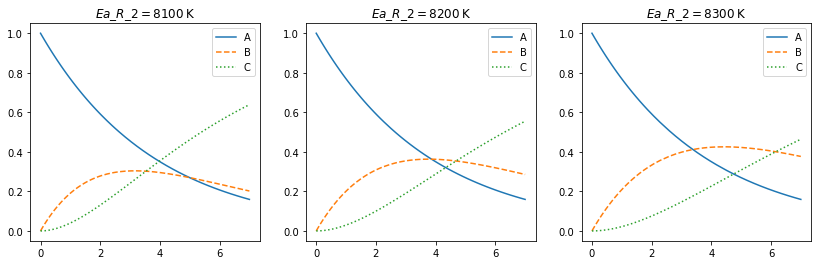

In [52]:
res2 = odesys.integrate(7*u.s, c0, params2, integrator='cvode')
fig, axes = plt.subplots(1, len(res2), figsize=(14, 4))
for r, ax in zip(res2, axes):
    r.plot(ax=ax)
    ax.set_title('$%s = %s$' % (pk.replace('_', '\\_'), number_to_scientific_latex(r.named_param('Ea_R_2'))))


We can also use ipywidgets to get interactive controls:


In [53]:
def integrate_and_plot(T_C=25):
    res = odesys.integrate(7*u.s, c0, dict(params, temperature=(T_C+273.15)*u.K), integrator='cvode')
    res.plot()
interact(integrate_and_plot)

interactive(children=(IntSlider(value=25, description='T_C', max=75, min=-25), Output()), _dom_classes=('widge…

<function __main__.integrate_and_plot(T_C=25)>